<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Topic Modeling and Latent Dirichlet Allocation (LDA)

---

### Learning Objectives
- See how search engines benefit from topic modeling.
- Visualize a simple example of term vectors.
- Walk through the coding of a simplified LDA topic model.
- Gain an intuition for what LDA is doing.
- Understand the pros and cons to LDA topic modeling.

### Lesson Guide
- [Introduction: search engines and topic modeling](#intro)
- [Term vector model visual example](#term-vector-ex)
- [How LDA works](#how-lda-works)
    - [Step 1: choose K topics](#step1)
    - [Step 2: randomly assign words in documents to topics](#step2)
    - [Step 3: word distributions of topics](#step3)
    - [Step 4: reassignment of topics](#step4)
    - [Step 5: getting words that define topics and topics that define documents](#step5)
    - [Major caveat: oversimplified!](#caveat)
- [LDA intuition](#lda-intuition)
- [LDA challenges](#lda-challenges)
- [LDA strengths](#lda-strengths)
- [Other models similar to LDA](#other-models)

<a id='intro'></a>
## Introduction: search engines and topic modeling
---

Search Engines use a variety of natural language processing techniques to provide an accurate query interface to documents on the internet.  Latent Dirichlet Allocation, which we will be discussing in this lecture, is just one of the many tools employed to improve search engine experience.



![](https://snag.gy/lbsuV2.jpg)

![](https://snag.gy/YdgxKz.jpg)

![](https://snag.gy/Ctr6OL.jpg)

![](https://snag.gy/ob9Um8.jpg)

<a id='term-vector-ex'></a>

## Term vector model visual example

---

The code below plots a basic example of differentiating between topics using *vectors*. Specifically, the similarity between vectors can be used to infer the similarity or dissimilarity between topics. 

In [1]:
%matplotlib inline

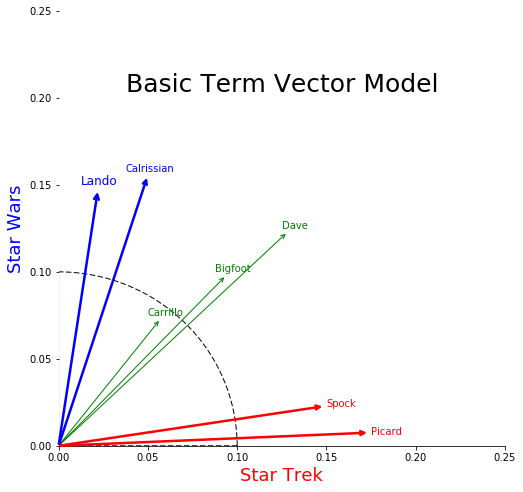

In [2]:
##### from scipy.interpolate import spline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib.patches as patches
from matplotlib.path import Path

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
theta1, theta2 = 0, 90
radius = .1
center = (0, 0)

# Main angle guide
w1 = Wedge(center, radius, theta1, theta2, fill=False, linestyle='dashed')
w1.set_linewidth(1)
ax.add_artist(w1)

# Vector examples
ax.annotate('Dave', (0, 0), (0.5, 0.5),
            arrowprops=dict(arrowstyle='<-', color="g"),
            xycoords='data', textcoords='axes fraction', color="g")

ax.annotate('Bigfoot', (0, 0), (0.35, 0.4),
            arrowprops=dict(arrowstyle='<-', color="g"),
            xycoords='data', textcoords='axes fraction', color="g")

ax.annotate('Carrillo', (0, 0), (0.2, 0.3),
            arrowprops=dict(arrowstyle='<-', color="g"),
            xycoords='data', textcoords='axes fraction', color="g")

ax.annotate('Calrissian', (0, 0), (0.15, 0.63),
            arrowprops=dict(arrowstyle='<-', color="b", linewidth=2.5),
            xycoords='data', textcoords='axes fraction', color="b")

ax.annotate('Lando', (0, 0), (0.05, 0.6),
            arrowprops=dict(arrowstyle='<-', color="b", linewidth=2.5),
            xycoords='data', textcoords='axes fraction', fontsize=12, color="b")

ax.annotate('Spock', (0, 0), (.6, 0.09),
            arrowprops=dict(arrowstyle='<-', color="r", linewidth=2.5),
            xycoords='data', textcoords='axes fraction', color="r")

ax.annotate('Picard', (0, 0), (.7, 0.025),
            arrowprops=dict(arrowstyle='<-', linewidth=2.5, color="r"),
            xycoords='data', textcoords='axes fraction', color="r")

# Remove splines on top and right
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.set_ylim([0, .25])
ax.set_xlim([0, .25])
ax.set_xmargin(.001)
ax.set_ymargin(.001)
ax.set_autoscale_on(False)


# x = np.linspace(0, 2*np.pi, 100)
# plt.plot(x)
plt.title("Basic Term Vector Model", fontsize=25, position=(0.5, 0.8))
plt.ylabel("Star Wars", fontsize=18, color="b")
plt.xlabel("Star Trek", fontsize=18, color="r")


plt.margins(0.005, 0.0001)

plt.show()

Each word in our corpus is related to either "Star Wars" or "Star Track".  We use a vector space model to calculate the distance of each word to each topic.

> Topics generated from an LDA model are actually a cluster of word probabilities, not clearly defined labels.  Simplifying word vectors like this, should give you a sense about the intuition of how **words vectors** relate to **topics**.

<a id='how-lda-works'></a>
## How LDA Works

---

_Abridged Explanation_

![](https://snag.gy/aiSFrm.jpg)

LDA isn't exactly straightforward when it comes to the math.  But we can explore this piecewise in more general terms.

In [4]:
import pandas as pd

In [5]:
yelp = pd.read_csv('./datasets/yelp.csv', encoding='utf-8')

In [6]:
from textblob import TextBlob

In [7]:
from sklearn.feature_extraction import stop_words
stopwords = stop_words.ENGLISH_STOP_WORDS

In [8]:
good = [list(TextBlob(x.lower()).words) for x in yelp[yelp.stars==5].text.values[0:25]]
bad = [list(TextBlob(x.lower()).words) for x in yelp[yelp.stars==1].text.values[0:25]]

In [9]:
good = [[w for w in doc if w not in stopwords] for doc in good]
bad = [[w for w in doc if w not in stopwords] for doc in bad]
good[11]

[u'time',
 u'friend',
 u'went',
 u'delicious',
 u'food',
 u'garlic',
 u'knots',
 u'favorite',
 u'course',
 u'wine',
 u'going',
 u'alot']

<a id='step1'></a>
### Step 1: choose K topics

Similar to the KNN algorithm. By setting K we are deciding up front on a preset number of topics to determine.

In [204]:
# A:

<a id='step2'></a>
### Step 2: randomly assign words in documents to topics

First let's denote the symbols for the different components:

$D$ represents the documents, $d$ is a document.

$W$ represents all the words in the documents, $w$ is a word.

$Z$ represents the collection of our $K$ topics, and $z$ is one of those topics.

We will start off with a completely random assignment of words to topics. Iterate through the documents $D$ and for each word $W$ in each document randomly assign the word to be in one of the $Z$ topics.

In [10]:
# get the documents and all the words

D = good+bad
W = [w for wordlist in D for w in wordlist]
print len(D), len(W)

50 2676


In [ ]:
# Here is an example of a dictionary comprehension
Z = {i:{w:0 for w in W_unique} for i in range(K)}

<a id='step3'></a>
### Step 3: word distributions of topics

Now that we have randomly assigned words to topics, we have the word distributions of different topics. These distributions indicate the probability of a word being in a topic. We can write out the probability of some given word being selected given a choice of one of our topics:

### $$ P(\text{word } w \;|\; \text{topic } z) $$

We also have the probability of *topic* occurance given a specific document, which is the proportion of words in a document that are assigned to a given topic.

### $$ P(\text{topic } z \;|\; \text{document } d) $$


In [210]:
# p(z|d): proportion of words in document d assigned to topic z


In [211]:
# p(w|z): proportion of words in topic z that are this word


<a id='step4'></a>
### Step 4: reassignment of topics

Now we will go through an iterative procedure. We will walk through the words in the documents many times. At each step we will calculate which topic a word should be reassigned to.

First we neet to calculate the probability associated with each topic:

### $$ P(\text{topic } z \;|\; \text{document } d) \cdot P(\text{word } w \;|\; \text{topic } z) $$

Which is the probability that the topic generated our current word. Below we can calculate the probability of a word in the first document being generated from each of our topics:

In [ ]:
# A:

We can write a function that will sample from the topics according to these probabilities to assign a new topic:

In [ ]:
# A:

To put it all together, we can write a a function that will iterate over all the words/documents a specified number of times and do the reassignment:

In [ ]:
# A:

<a id='step5'></a>
### Step 5: getting words that define topics and topics that define documents

To get the topic distribution for a document we can use the function that calculated the probability of a topic given a document from before.

In [ ]:
# A:

Let's check it out for the first 3 documents:

In [ ]:
# A:

To get the words that define topics we can just calculate the words that have greatest probability of occuring for a given topic

In [ ]:
# A:

<a id='caveat'></a>
### Major caveat: oversimplified!

This is a dumb, oversimplified version of LDA. We've completely ignored priors and didn't talk about the Dirichlet distribution at all. That being said, this is the general breakdown of whats going on. We perform a procedure where we assign words to topics based on how likely a topic would have generated that word. 

> **Note:** More legitimate implementations of LDA have hyperparameters such as alpha. Alpha is a scaler that helps minimize an error term.  Thankfully, most LDA models that are implented will set this automatically and it's usually, 95% of the time a fine solution.  To really get a strong handle of the math behind this model, there are whitepapers you can read.  Also, having a strong handle on Bayesian statistic is a must to really grasp this model at it's lowest levels.  We are not going there today!


<a id='lda-intuition'></a>
## LDA Intuition

---
 
As we iterate through each word in our corpus and (re)assign it to a topic:

1. Words become more common in topics where they are already common.
1. Topics will become more common in documents where they are already common.

**Remember:**:
- Words are assigned to topics randomly at first
- As words are found to be consistently distributed within topics, the model achieves a sort of equilibrium based on the distribution of words accross all documents.

<a id='lda-challenges'></a>
## LDA challenges

---

1. **There's a bit of entropy to topics.**
There can be between 1-10% shift in what is generated in LDA models.  You may not get the same thing 2x!

1. **Can be very difficult to assess.**
If you have a large corpus, with many topics (>10), it's damn near impossible to visualize the distribution of documents to topics.

1. **Preprocessing is heavy.**
To get the most out of LDA, cleaning stopwords, and specific language can be a challenging task.  Sometimes it's difficult to avoid the noise involved with this model.

1. **SME is necessary for accurate topic assessment.**
The more straight forward your text is, the less subject matter expertise is required.  A more advanced use of LDA would involve assessing documents with lots of idiomtic language. Knowing what topics are found, can be subjective.

1.  **Determining what topics mean is tricky.**
A collection of world probabiltiies generally isn't very intuitive.  You could take the first word and use that as your topic "label".  Hence, more subject matter expertise is required.

1. **LDA is unsupervised.**
It's not possible to know what is "correct".  The repsonse topics are generated. LDA is known as a "generative" model. 

1. **Tuning your LDA model can be tough."**
It's possible to tune for the parameter **K** *number of topics*, but it's not necessarily a very straightforward way to improve your model.



<a id='lda-strengths'></a>
## LDA strengths

---

1. **It can be very strong performer in production.**
After you build the model, it can easily be used "online".
> "Online" training allows you to update your model with more training data without having to refit all your data.  Only new data can be fit globally.

1.  **It's easy to get a quick sense of what a large body of text is broadly "about", without having to read all of it.** Rather than reading 12k PDF's on corproate policies, you could extract the text, and run LDA to see what generalities it finds.
1.  **Easily classify / tag documents by topic.**
1.  **It can "just work" out of the box.**  However, your mileage will vary depending on your preprocessing.

<a id='other-models'></a>
## Other models similar to LDA

---

- Topics Over Time
- Dynamic Topic Modeling
- Hierarchical LDA
- Pachinko Allocation 

A cool new LDA model to look out for:

- [LDA2Vec](http://multithreaded.stitchfix.com/blog/2016/05/27/lda2vec/)